In [3]:
import pandas as pd
import numpy as np
from LabData.DataLoaders.UkbbLoader import UkbbLoader
from LabData import config_global as config

from scipy.stats import ks_2samp, mannwhitneyu
import UKBB_survival 
from UKBB_survival import get_mean_of_repeating_columns
from LabData.DataAnalyses.TenK_Trajectories.UKBB_10K.ukbb_10K_predictions_for_distribution_matching import \
   add_sex_gender_to_df, rename_ukbb_fields_to_match_tenks_names, remove_outliers_for_dfs, \
   unit_correction_and_remove_outliers

%matplotlib inline
import matplotlib.pyplot as plt

import pickle,re

from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.ECGTextLoader import ECGTextLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.Medications10KLoader import Medications10KLoader
from LabData.DataLoaders.IBSTenkLoader import IBSTenkLoader


In [2]:
ukbbloader = UkbbLoader()
cols_df = ukbbloader.get_available_ukbb_cols()
cols_list = cols_df.values
#ukbb = ukbbloader.get_data(by='field_id',which=[19,105030],instances = [0,1,2])



In [5]:
#features_table = pd.read_csv('/home/davidpel/PycharmProjects/LabData/LabData/DataAnalyses/TenK_Trajectories/UKBB_10K/ukbb_tenk_mapping.csv').dropna(how='all')
#cols_file = open(UkbbLoader.available_ukbb_cols_file,'rb')
#avl_cols = pickle.load(cols_file)
#cols_file.close()
#fields = pd.read_csv(UkbbLoader.ukbb_fields_file)
#fields.iloc[100:150]


In [6]:
FEATURE_MAPPING = '/home/davidpel/PycharmProjects/UKBB_10k/joint_features.csv'

features_table = pd.read_csv(FEATURE_MAPPING).dropna(how='all')
features_table.columns
# ukbb_fields = features_table['UKBB Field ID'].to_list()
# ukbb_loader = UkbbLoader()
# ukbb_data = ukbb_loader.load_ukbb(which = ukbb_fields)
# ukbb_data.rename(columns={k: k.split(' - visit')[0] for k in ukbb_data.columns}, inplace=True)
# ukbb_data = get_mean_of_repeating_columns(ukbb_data)
# ukbb_data.info()


Index(['10K Name', ' Loader', ' UKBB Description', ' UKBB Field ID'], dtype='object')

In [12]:

LOADER_MAPPING = {'BodyMeasures': BodyMeasuresLoader,
                 'BloodTests': BloodTestsLoader,
                 #'MedicationLoader': Medications10KLoader,
                 'LifeStyle': LifeStyleLoader,
                 'ECGLoader': ECGTextLoader,
                  'IBSTenkLoader': IBSTenkLoader}

In [13]:

tenk_data = pd.DataFrame()
for loader in set(pd.unique(features_table['loader_name']).tolist()).intersection(set(LOADER_MAPPING.keys())):
    print(loader)
    features = features_table['ten_k_name'][features_table['loader_name'] == loader].to_list()
    if loader == 'BodyMeasures':
        data = add_sex_gender_to_df(LOADER_MAPPING[loader]().get_data(study_ids=['10K'], research_stage=['baseline'],
                                                                     groupby_reg='first', min_col_present_frac=0.5,
                                                                     cols=features)).df
    else:
        data = LOADER_MAPPING[loader]().get_data(study_ids=['10K'], research_stage=['baseline'],
                                             groupby_reg='first', cols=features, min_col_present_frac=0.5
                                             ).df
    data = data.reset_index(level=[1]).drop(['Date'], axis=1)
    tenk_data = pd.concat([tenk_data, data], axis=1)

LifeStyle
BodyMeasures
IBSTenkLoader
ECGLoader
BloodTests


In [18]:
col = tenk_data['water_glasses_day']
col.name

'water_glasses_day'

In [3]:
tenk_data = tenk_data.fillna(np.nan).astype(float)
ukbb_data = ukbb_data.fillna(np.nan)
#     if COLUMN_TO_CONV_TO_NUM is not None:
#         for col in COLUMN_TO_CONV_TO_NUM:
#             tenk_data[col] = tenk_data[col].astype(float)
ukbb_data = unit_correction_and_remove_outliers(ukbb_data.copy()).dropna(how='all')
tenk_data = unit_correction_and_remove_outliers(tenk_data.copy(), features_table,
                                                    unit_correction=True).dropna(how='all')
ukbb_data = rename_ukbb_fields_to_match_tenks_names(ukbb_data, tenk_data, features_table)

NameError: name 'tenk_data' is not defined

In [7]:
tenk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11834 entries, 10K_1000942861 to 10K_9862849963
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   waist                              9167 non-null   float64
 1   hips                               9173 non-null   float64
 2   hand_grip_right                    9086 non-null   float64
 3   sitting_blood_pressure_diastolic   9159 non-null   float64
 4   sitting_blood_pressure_systolic    9151 non-null   float64
 5   height                             9145 non-null   float64
 6   weight                             9139 non-null   float64
 7   sitting_blood_pressure_pulse_rate  9151 non-null   float64
 8   bmi                                9136 non-null   float64
 9   age                                9123 non-null   float64
 10  gender                             9312 non-null   float64
 11  bt__hba1c                          60

In [8]:
ukbb_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 502409 entries, 1000016 to 6026225
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   waist                              492332 non-null  float64
 1   hips                               491238 non-null  float64
 2   hand_grip_right                    491373 non-null  float64
 3   sitting_blood_pressure_diastolic   463456 non-null  float64
 4   sitting_blood_pressure_systolic    463389 non-null  float64
 5   height                             492599 non-null  float64
 6   weight                             489760 non-null  float64
 7   sitting_blood_pressure_pulse_rate  463245 non-null  float64
 8   bmi                                489316 non-null  float64
 9   age                                499978 non-null  float64
 10  gender                             502409 non-null  float64
 11  bt__hba1c                       

In [43]:
#ukbb_data.hist(figsize = (30,25),color='b',density=True)
#tenk_data.hist(alpha=0.5,color='r',density =True)

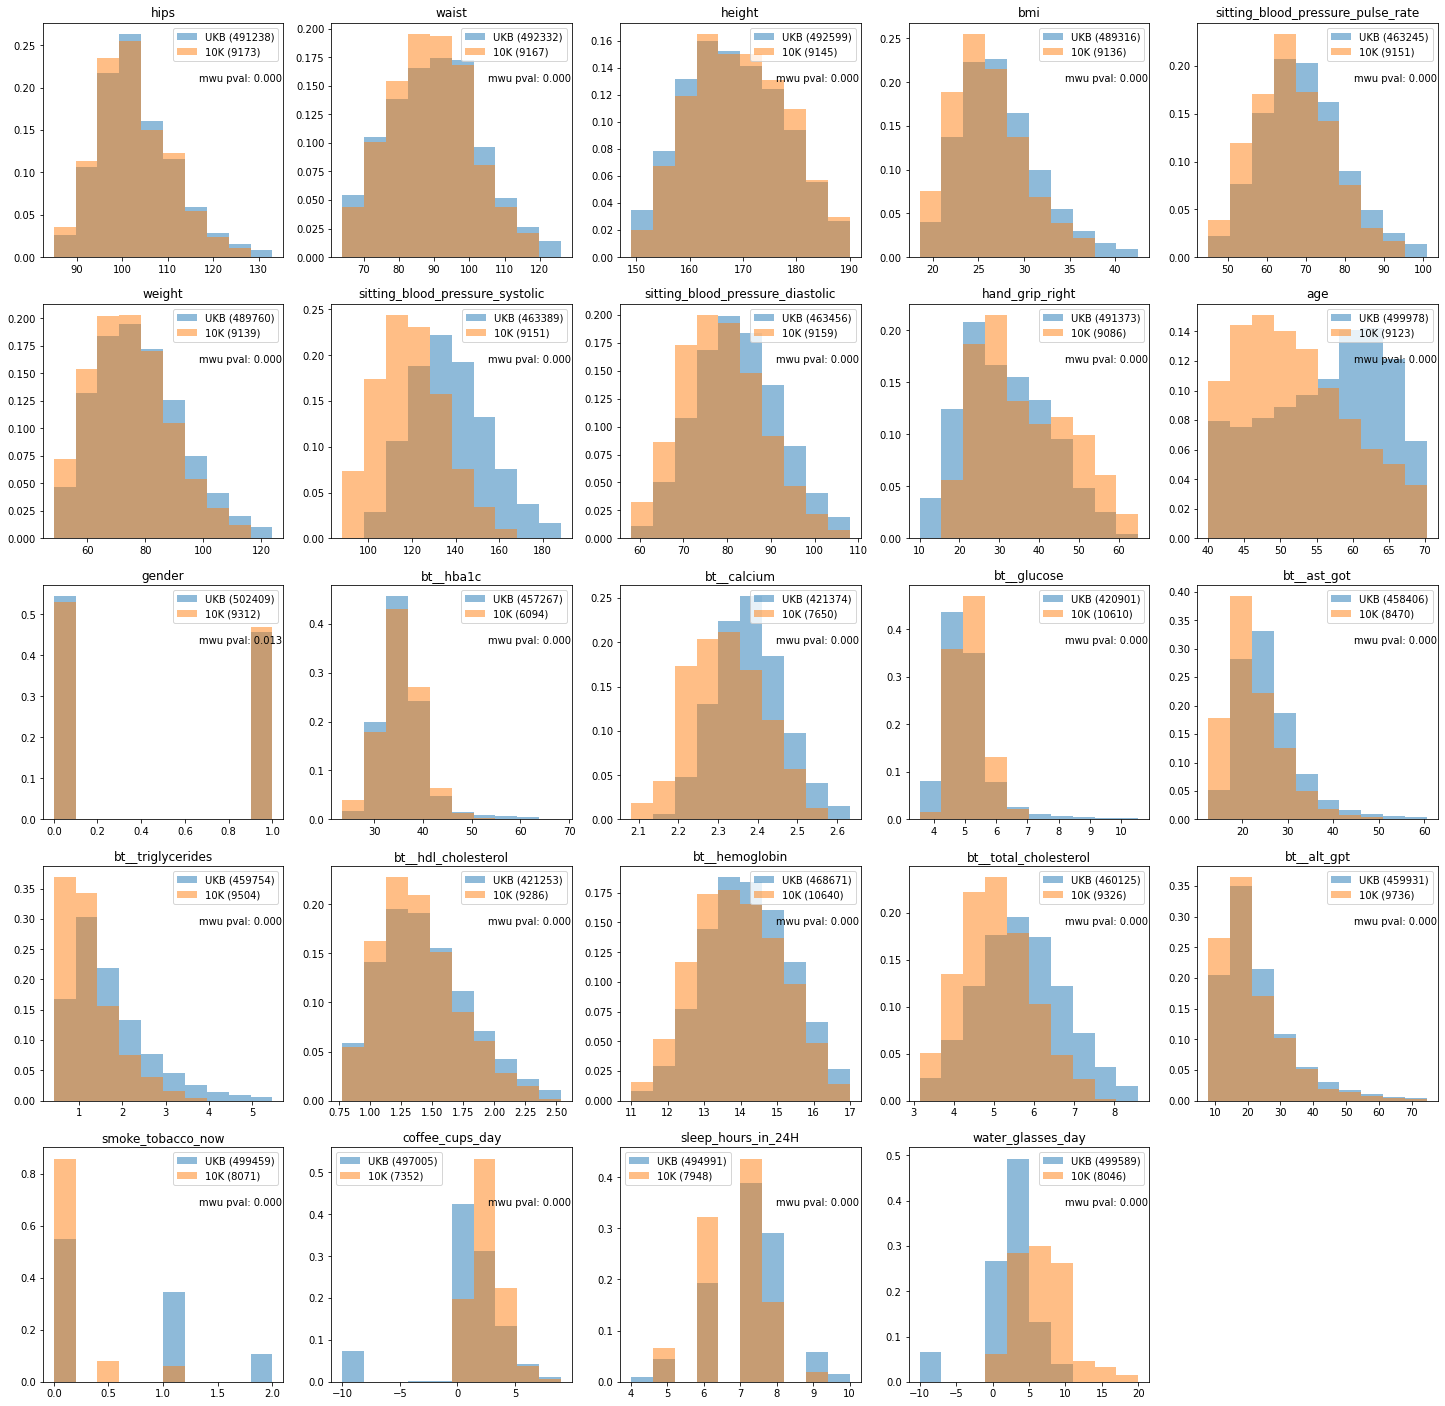

In [17]:
fig=plt.figure(figsize=(25,25))
fig.subplots_adjust(hspace=0.2)
for i,val in enumerate(tenk_data.columns):
    ax=plt.subplot(5,5,i+1)
    minx = min(min(ukbb_data[val].dropna()),min(tenk_data[val].dropna()))
    maxx = max(max(ukbb_data[val].dropna()),max(tenk_data[val].dropna()))
    ukbb_hist,ukbb_bins = np.histogram(ukbb_data[val].dropna(),range=(minx,maxx))
    ukbb_hist = ukbb_hist/np.sum(ukbb_hist)
    #print(ukbb_bins)
    tenk_hist,tenk_bins = np.histogram(tenk_data[val].dropna(),range=(minx,maxx))
    #print(tenk_bins)
    tenk_hist = tenk_hist/np.sum(tenk_hist)
    #ax.hist(ukbb_data[val].dropna(),color='b',alpha=0.7,range=(minx,maxx),density=True,label="UKBB ({})".format(len(ukbb_data[val].dropna())))
    #ax.hist(tenk_data[val].dropna(),alpha=0.5,color='r',range=(minx,maxx),density =True,label="10K ({})".format(len(tenk_data[val].dropna())))
    ax.bar(ukbb_bins[:-1],ukbb_hist,alpha=0.5,label="UKB ({})".format(len(ukbb_data[val].dropna())),width=np.diff(ukbb_bins),align='edge')
    ax.bar(tenk_bins[:-1],tenk_hist,alpha=0.5,label="10K ({})".format(len(tenk_data[val].dropna())),width=np.diff(tenk_bins),align='edge')
    ax.set_title(val)
    ax.legend()
    u,p = mannwhitneyu(ukbb_data[val].dropna(),tenk_data[val].dropna())
    ax.text(0.65,0.75,"mwu pval: {:.3f}".format(p),transform=ax.transAxes)


In [50]:
tenk_data['bt__calcium']

RegistrationCode
10K_1000942861         NaN
10K_1001201093         NaN
10K_1002033709         NaN
10K_1002087123    0.241264
10K_1002254441    0.253418
                    ...   
10K_8598413244         NaN
10K_9163510180         NaN
10K_9220094672         NaN
10K_9459547666         NaN
10K_9862849963         NaN
Name: bt__calcium, Length: 11834, dtype: float64

In [25]:
tenk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11901 entries, 10K_1000942861 to 10K_9170473452
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   bt__hemoglobin                     10851 non-null  float64
 1   bt__calcium                        7782 non-null   float64
 2   bt__triglycerides                  9683 non-null   float64
 3   bt__alt_gpt                        9923 non-null   float64
 4   bt__hdl_cholesterol                9461 non-null   float64
 5   bt__glucose                        10807 non-null  float64
 6   bt__hba1c                          6201 non-null   float64
 7   bt__ast_got                        8641 non-null   float64
 8   bt__total_cholesterol              9516 non-null   float64
 9   sitting_blood_pressure_pulse_rate  9328 non-null   float64
 10  hand_grip_right                    9270 non-null   float64
 11  height                             93

In [37]:
md = Medications10KLoader().get_data(study_ids=['10K'], research_stage=['baseline'],
                                             groupby_reg='first', cols=features, min_col_present_frac=0.5
                                             ).df

Unprocessed medications in metadata - more than defined threshold of 3
column_name
וסיקר / Vesicare         5
נאורונטין / Neurontin    4
קיי-ציטק / K-Citek       4
פמארל / femarelle        4
סינומל / Cynomel         4
dtype: int64


In [36]:
md

,,,updated_at,research_stage,end_year,collection_method,start_year,created_at,end_month,source_updated_at,start_month,gender,StudyTypeID2,city,country,StudyTypeID3,us_state,yob,StudyTypeID,age,tz
RegistrationCode,medication,Date,,,,,,,,,,,,,,,,,,,
10K_1000633050,סטטור / Stator,2021-06-21 14:23:50.920992,2021-08-15 13:59:35.679198+00:00,baseline,NaN,web interface,NaN,2021-08-15 13:59:35.679188+00:00,NaN,2021-06-21 14:23:50.921008+00:00,NaN,0.0,NaN,None,IL,NaN,None,1955.0,10.0,66.0,Asia/Jerusalem
10K_1000942861,סימבלטה / Cymbalta,2021-06-11 11:30:37.992594,2021-08-15 13:59:35.583725+00:00,baseline,NaN,web interface,NaN,2021-08-15 13:59:35.583711+00:00,NaN,2021-06-11 11:30:37.992609+00:00,NaN,1.0,NaN,None,IL,NaN,None,1967.0,10.0,54.0,Asia/Jerusalem
10K_1002032358,אקטיבל / activelle,2022-05-01 07:32:52.646197,2022-05-08 03:04:23.728705+00:00,baseline,NaN,web interface,NaN,2022-05-08 03:04:23.728685+00:00,NaN,2022-05-01 07:32:52.646210+00:00,NaN,0.0,NaN,None,IL,NaN,None,1969.0,10.0,53.0,Asia/Jerusalem
10K_1002254441,סרנדה / Serenada,2022-08-29 18:34:08.557905,2022-09-04 03:04:56.215977+00:00,baseline,NaN,web interface,NaN,2022-09-04 03:04:56.215958+00:00,NaN,2022-08-29 18:34:08.557915+00:00,NaN,1.0,NaN,None,IL,NaN,None,1977.0,10.0,45.0,Asia/Jerusalem
10K_1007330152,דופלקס 5/160 / duplex 5/160,2020-08-15 06:05:30.121685,2022-01-26 15:25:37.395070+00:00,baseline,NaN,web interface,NaN,2020-08-15 06:05:30.121685+00:00,NaN,2022-01-26 15:25:37.395070+00:00,NaN,1.0,NaN,None,IL,NaN,None,1957.0,10.0,63.0,Asia/Jerusalem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9995551134,ליפיטור / Lipitor,2020-08-20 21:25:19.281231,2022-01-26 15:25:37.395070+00:00,baseline,NaN,web interface,NaN,2020-08-20 21:25:19.281231+00:00,NaN,2022-01-26 15:25:37.395070+00:00,NaN,1.0,NaN,None,IL,NaN,None,1960.0,10.0,60.0,Asia/Jerusalem
10K_9995623290,סילריל / Cilaril,2020-01-13 09:47:10.995608,2022-01-26 15:25:37.395070+00:00,baseline,NaN,web interface,NaN,2020-01-13 09:47:10.995608+00:00,NaN,2022-01-26 15:25:37.395070+00:00,NaN,1.0,NaN,None,IL,NaN,None,1966.0,10.0,54.0,Asia/Jerusalem
10K_9997760024,אלטרוקסין / Eltroxin,2019-11-03 20:21:29.190126,2022-01-26 15:25:37.395070+00:00,baseline,NaN,web interface,NaN,2019-11-03 20:21:29.190126+00:00,NaN,2022-01-26 15:25:37.395070+00:00,NaN,0.0,NaN,None,IL,NaN,None,1956.0,10.0,63.0,Asia/Jerusalem


In [34]:
pd.get_dummies(md.reset_index(level='medication'))


,,medication_Ritalin LA / ריטלין LA,medication_Rizalt RPD / ריזלט,medication_Vitamin D / ויטמין D,medication_אבאמיס / AVAMYS,medication_אבודרט / Avodart,medication_אביאנה / Eviana,medication_אבילק / Avilac,medication_אביסטה / Evista,medication_אבץ + ויטמין C / Zinc +Vitamin C,medication_אדוויל / Advil,...,medication_ריטלין / N/A,medication_ריטלין / Ritalin,medication_ריטלין LA / Ritalin LA,medication_רילרט / Relert,medication_רלבר אליפטה / Relvar Ellipta,medication_רמוטיב / Remotiv,medication_רמיפריל טבע / Ramipril Teva,medication_רסיטל / Recital,medication_רפאטה / Repatha,medication_תוריד / Torid
RegistrationCode,Date,,,,,,,,,,,,,,,,,,,,,
10K_1000633050,2021-06-21 14:23:50.920992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10K_1000942861,2021-06-11 11:30:37.992594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10K_1002032358,2022-05-01 07:32:52.646197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10K_1002254441,2022-08-29 18:34:08.557905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10K_1007330152,2020-08-15 06:05:30.121685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9995551134,2020-08-20 21:25:19.281231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10K_9995623290,2020-01-13 09:47:10.995608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10K_9997760024,2019-11-03 20:21:29.190126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
